📦 Loading patch data ...
🧠 Loading encoder ...
🔍 Extracting latent embeddings ...
✅ Extracted shape: (2399, 4096)
📉 Reducing with UMAP ...


/home/michael/programming_projects/self_supervised_ocean/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


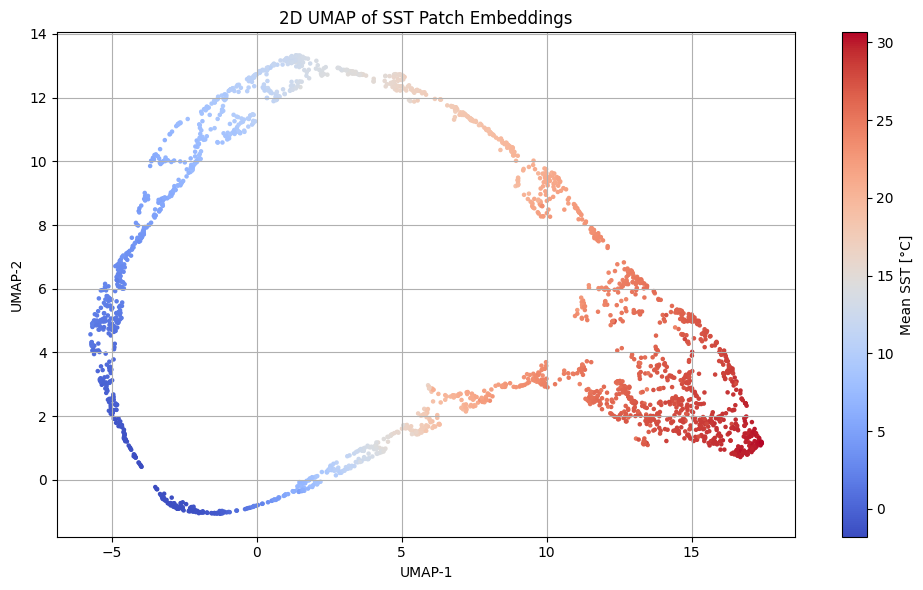

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# UMAP for visualization (install with: pip install umap-learn)
import umap

# --- Setup paths ---
project_root = Path("..").resolve()
sys.path.append(str(project_root / "src"))
from autoencoder import SSTAutoencoder

patch_path = project_root / "data/patches/sst_patches_64x64.npy"
model_path = project_root / "outputs/sst_autoencoder.pth"

# --- Load data ---
print("📦 Loading patch data ...")
patches = np.load(patch_path)
patches = np.nan_to_num(patches, nan=0.0)
patches_tensor = torch.tensor(patches).unsqueeze(1).float()  # (N, 1, 64, 64)

# --- Load model & get encoder only ---
print("🧠 Loading encoder ...")
full_model = SSTAutoencoder()
full_model.load_state_dict(torch.load(model_path, map_location="cpu"))
encoder = full_model.encoder
encoder.eval()

# --- Extract embeddings ---
print("🔍 Extracting latent embeddings ...")
with torch.no_grad():
    embeddings = encoder(patches_tensor).numpy()  # shape: (N, C, H, W)

# Flatten spatial output to a vector
embeddings_flat = embeddings.reshape(len(embeddings), -1)
print(f"✅ Extracted shape: {embeddings_flat.shape}")  # e.g., (5000, 4096)

# --- Reduce to 2D using UMAP ---
print("📉 Reducing with UMAP ...")
reducer = umap.UMAP()
embedding_2d = reducer.fit_transform(embeddings_flat)

# --- Optional: Color by mean SST per patch ---
mean_sst = patches.reshape(len(patches), -1).mean(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=mean_sst, cmap="coolwarm", s=5)
plt.colorbar(label="Mean SST [°C]")
plt.title("2D UMAP of SST Patch Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.savefig(project_root / "results" / "figures" / "2D_UMAP_of_SST_Patch_Embeddings.png", dpi=300, bbox_inches="tight")
plt.show()

# 💾 Save UMAP embeddings
output_path = project_root / "outputs"
output_path.mkdir(parents=True, exist_ok=True)
np.save(output_path / "sst_umap_embeddings.npy", embedding_2d)